# DEIS Sampling Method Testing

This notebook tests the **DEIS (Diffusion Exponential Integrator Sampler)** method using `DEISMultistepScheduler` from the diffusers library.

DEIS is a fast high-order solver for diffusion ODEs that can generate high-quality samples with fewer function evaluations.

## Hyperparameters tested:
- **Number of inference steps** (5, 10, 20, 50, 100)
- **Solver order** (1, 2, 3)
- **Beta schedule** (linear, scaled_linear, squaredcos_cap_v2)
- **Solver type** (logrho, midpoint, heun, bh1, bh2)
- **Lower order final** (True, False)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import time

from ema_pytorch import EMA
from torchvision.utils import make_grid, save_image
from diffusers import DEISMultistepScheduler

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

from diffusion.ddpm import Unet, GaussianDiffusion

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Load Pretrained Model

In [2]:
# Model configuration (should match training config)
IMAGE_SIZE = 28
CHANNELS = 3
TIMESTEPS = 1000

# Initialize model architecture
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    flash_attn=False,
    channels=CHANNELS
)

# Create diffusion wrapper (needed for loading checkpoint)
diffusion = GaussianDiffusion(
    model,
    image_size=IMAGE_SIZE,
    timesteps=TIMESTEPS,
    sampling_timesteps=250
)

## FID Evaluation Setup

We'll use FID (Fréchet Inception Distance) to quantitatively compare sample quality across different DEIS configurations.


In [3]:
class ImageFolderDataset(Dataset):
    """Dataset for loading images from a folder for FID computation."""
    def __init__(self, root, image_size=299):
        self.root = Path(root)
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]
        self.paths = sorted(
            p for ext in exts for p in self.root.rglob(f"*{ext}")
        )

        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {self.root}")

        self.transform = T.Compose([
            T.ConvertImageDtype(torch.float32),
        ])
        self.resize = T.Resize((image_size, image_size))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")  
        img = self.resize(img)
        img = T.functional.to_tensor(img)
        return img


@torch.no_grad()
def compute_fid(
    real_dir: str,
    fake_dir: str,
    batch_size: int = 16,  # Reduced batch size to avoid OOM
    device: str = None,
    num_workers: int = 4,
) -> float:
    """
    Compute FID score between real and generated images.
    
    Args:
        real_dir: Path to directory containing real images
        fake_dir: Path to directory containing generated images
        batch_size: Batch size for processing
        device: Device to use for computation
        num_workers: Number of workers for data loading
    
    Returns:
        FID score (lower is better)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    real_ds = ImageFolderDataset(real_dir)
    fake_ds = ImageFolderDataset(fake_dir)

    real_loader = DataLoader(
        real_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    fake_loader = DataLoader(
        fake_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid.eval()

    for imgs in real_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=True)
        del imgs  # Free memory immediately

    for imgs in fake_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=False)
        del imgs  # Free memory immediately

    value = fid.compute().item()
    
    # Clean up FID model to free GPU memory
    del fid
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return value


@torch.no_grad()
def compute_fid_from_tensors(
    real_images: torch.Tensor,
    fake_images: torch.Tensor,
    device: str = None,
) -> float:
    """
    Compute FID score directly from image tensors.
    
    Args:
        real_images: Tensor of real images (N, C, H, W) in [0, 1]
        fake_images: Tensor of generated images (N, C, H, W) in [0, 1]
        device: Device to use for computation
    
    Returns:
        FID score (lower is better)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid.eval()
    
    # Resize to 299x299 for Inception
    resize = T.Resize((299, 299), antialias=True)
    
    # Process real images in batches
    batch_size = 64
    for i in range(0, len(real_images), batch_size):
        batch = real_images[i:i+batch_size].to(device)
        batch = resize(batch)
        # Convert to uint8 [0, 255] as expected by FID
        batch = (batch * 255).to(torch.uint8)
        fid.update(batch, real=True)
    
    # Process fake images in batches
    for i in range(0, len(fake_images), batch_size):
        batch = fake_images[i:i+batch_size].to(device)
        batch = resize(batch)
        batch = (batch * 255).to(torch.uint8)
        fid.update(batch, real=False)
    
    value = fid.compute().item()
    return value


def save_samples_to_dir(samples: torch.Tensor, output_dir: Path, prefix: str = "sample"):
    """Save tensor samples as individual images to a directory."""
    output_dir.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(samples):
        img_path = output_dir / f"{prefix}_{i:04d}.png"
        save_image(img, img_path)
    return output_dir


In [4]:
# Load checkpoint
CKPT_PATH = "./ckpts/model-5.pt"  # Update this path to your checkpoint

ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=False)
diffusion.load_state_dict(ckpt["model"])

# Setup EMA model
ema = EMA(diffusion, beta=0.995, update_every=10).to(device)
ema.load_state_dict(ckpt["ema"])

# Get the EMA model for inference
ema_model = ema.ema_model
ema_model.eval()

# Extract the UNet from the diffusion model
unet = ema_model.model
unet.eval()

print(f"Model loaded from: {CKPT_PATH}")

Model loaded from: ./ckpts/model-5.pt


## DEIS Sampling Implementation

We create a sampling function that uses the `DEISMultistepScheduler` with our trained UNet.

In [5]:
def create_deis_scheduler(
    num_train_timesteps: int = 1000,
    beta_schedule: str = "scaled_linear",
    beta_start: float = 0.0001,
    beta_end: float = 0.02,
    solver_order: int = 2,
    algorithm_type: str = "deis",
    solver_type: str = "logrho",
    lower_order_final: bool = True,
):
    """
    Create a DEIS scheduler with specified parameters.
    
    Args:
        num_train_timesteps: Number of training timesteps
        beta_schedule: Type of beta schedule ('linear', 'scaled_linear', 'squaredcos_cap_v2')
        beta_start: Starting beta value
        beta_end: Ending beta value
        solver_order: Order of the DEIS solver (1, 2, or 3)
        algorithm_type: Algorithm type ('deis' or 'dpmsolver++')
        solver_type: Solver type ('logrho', 'midpoint', 'heun', 'bh1', 'bh2')
        lower_order_final: Use lower order solver at final steps
    """
    scheduler = DEISMultistepScheduler(
        num_train_timesteps=num_train_timesteps,
        beta_schedule=beta_schedule,
        beta_start=beta_start,
        beta_end=beta_end,
        solver_order=solver_order,
        algorithm_type=algorithm_type,
        solver_type=solver_type,
        lower_order_final=lower_order_final,
        prediction_type="epsilon",  # Our model predicts noise
    )
    return scheduler

In [6]:
@torch.inference_mode()
def sample_with_deis(
    unet,
    scheduler,
    num_inference_steps: int = 20,
    batch_size: int = 16,
    image_size: int = 28,
    channels: int = 3,
    device: str = 'cuda',
    return_intermediates: bool = False,
):
    """
    Sample images using DEIS scheduler.
    
    Args:
        unet: The denoising UNet model
        scheduler: DEIS scheduler instance
        num_inference_steps: Number of denoising steps
        batch_size: Number of images to generate
        image_size: Size of generated images
        channels: Number of image channels
        device: Device to use
        return_intermediates: Whether to return intermediate samples
    
    Returns:
        samples: Generated images (batch_size, channels, image_size, image_size)
        intermediates: List of intermediate samples (if return_intermediates=True)
        elapsed_time: Time taken for sampling
    """
    # Set number of inference steps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps
    
    # Initialize with random noise
    latents = torch.randn(
        (batch_size, channels, image_size, image_size),
        device=device,
        dtype=torch.float32
    )
    
    # Scale initial noise by the scheduler's init_noise_sigma
    latents = latents * scheduler.init_noise_sigma
    
    intermediates = [latents.clone()] if return_intermediates else None
    
    # Denoising loop
    for t in tqdm(timesteps, desc="DEIS Sampling", leave=False):
        # Create batched timesteps
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # Predict noise
        noise_pred = unet(latents, t_batch)
        
        # DEIS step
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if return_intermediates:
            intermediates.append(latents.clone())
    
    # Unnormalize from [-1, 1] to [0, 1]
    samples = (latents + 1) * 0.5
    samples = samples.clamp(0, 1)
    
    if return_intermediates:
        intermediates = [(x + 1) * 0.5 for x in intermediates]
        return samples, intermediates
    
    return samples

## Helper Functions for Visualization

In [7]:
def show_samples(samples, title="Generated Samples", nrow=4, figsize=(10, 10)):
    """Display a grid of generated samples."""
    grid = make_grid(samples, nrow=nrow, padding=2, normalize=False)
    grid = grid.cpu().permute(1, 2, 0).numpy()
    
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def show_denoising_process(intermediates, num_steps_to_show=8, nrow=8, figsize=(16, 4)):
    """Visualize the denoising process."""
    n_intermediates = len(intermediates)
    indices = np.linspace(0, n_intermediates - 1, num_steps_to_show, dtype=int)
    
    selected = [intermediates[i][0:1] for i in indices]  # Take first sample
    selected = torch.cat(selected, dim=0)
    
    grid = make_grid(selected, nrow=nrow, padding=2, normalize=False)
    grid = grid.cpu().permute(1, 2, 0).numpy().clip(0, 1)
    
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.title("Denoising Process (Noise -> Image)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def compare_results(results_dict, figsize=(16, 12)):
    """Compare samples from different configurations."""
    n_configs = len(results_dict)
    fig, axes = plt.subplots(n_configs, 1, figsize=figsize)
    
    if n_configs == 1:
        axes = [axes]
    
    for ax, (name, data) in zip(axes, results_dict.items()):
        samples = data['samples'][:8]  # Show first 8 samples
        grid = make_grid(samples, nrow=8, padding=2, normalize=False)
        grid = grid.cpu().permute(1, 2, 0).numpy()
        
        ax.imshow(grid)
        ax.set_title(f"{name}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

---
## Experiment 1: Varying Number of Inference Steps

Test how sample quality changes with different numbers of denoising steps.

In [13]:
# Test different numbers of inference steps
step_counts = [5, 10, 20, 50, 100]

results_steps = {}

for num_steps in step_counts:
    print(f"\nSampling with {num_steps} steps...")
    
    scheduler = create_deis_scheduler(
        num_train_timesteps=TIMESTEPS,
        solver_order=2,
        beta_schedule="scaled_linear",
    )
    
    samples = sample_with_deis(
        unet=unet,
        scheduler=scheduler,
        num_inference_steps=num_steps,
        batch_size=16,
        image_size=IMAGE_SIZE,
        channels=CHANNELS,
        device=device
    )
    
    results_steps[f"{num_steps} steps"] = {
        'samples': samples,
    }


Sampling with 5 steps...


DEIS Sampling:   0%|          | 0/5 [00:00<?, ?it/s]


Sampling with 10 steps...


DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]


Sampling with 20 steps...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with 50 steps...


DEIS Sampling:   0%|          | 0/50 [00:00<?, ?it/s]


Sampling with 100 steps...


DEIS Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

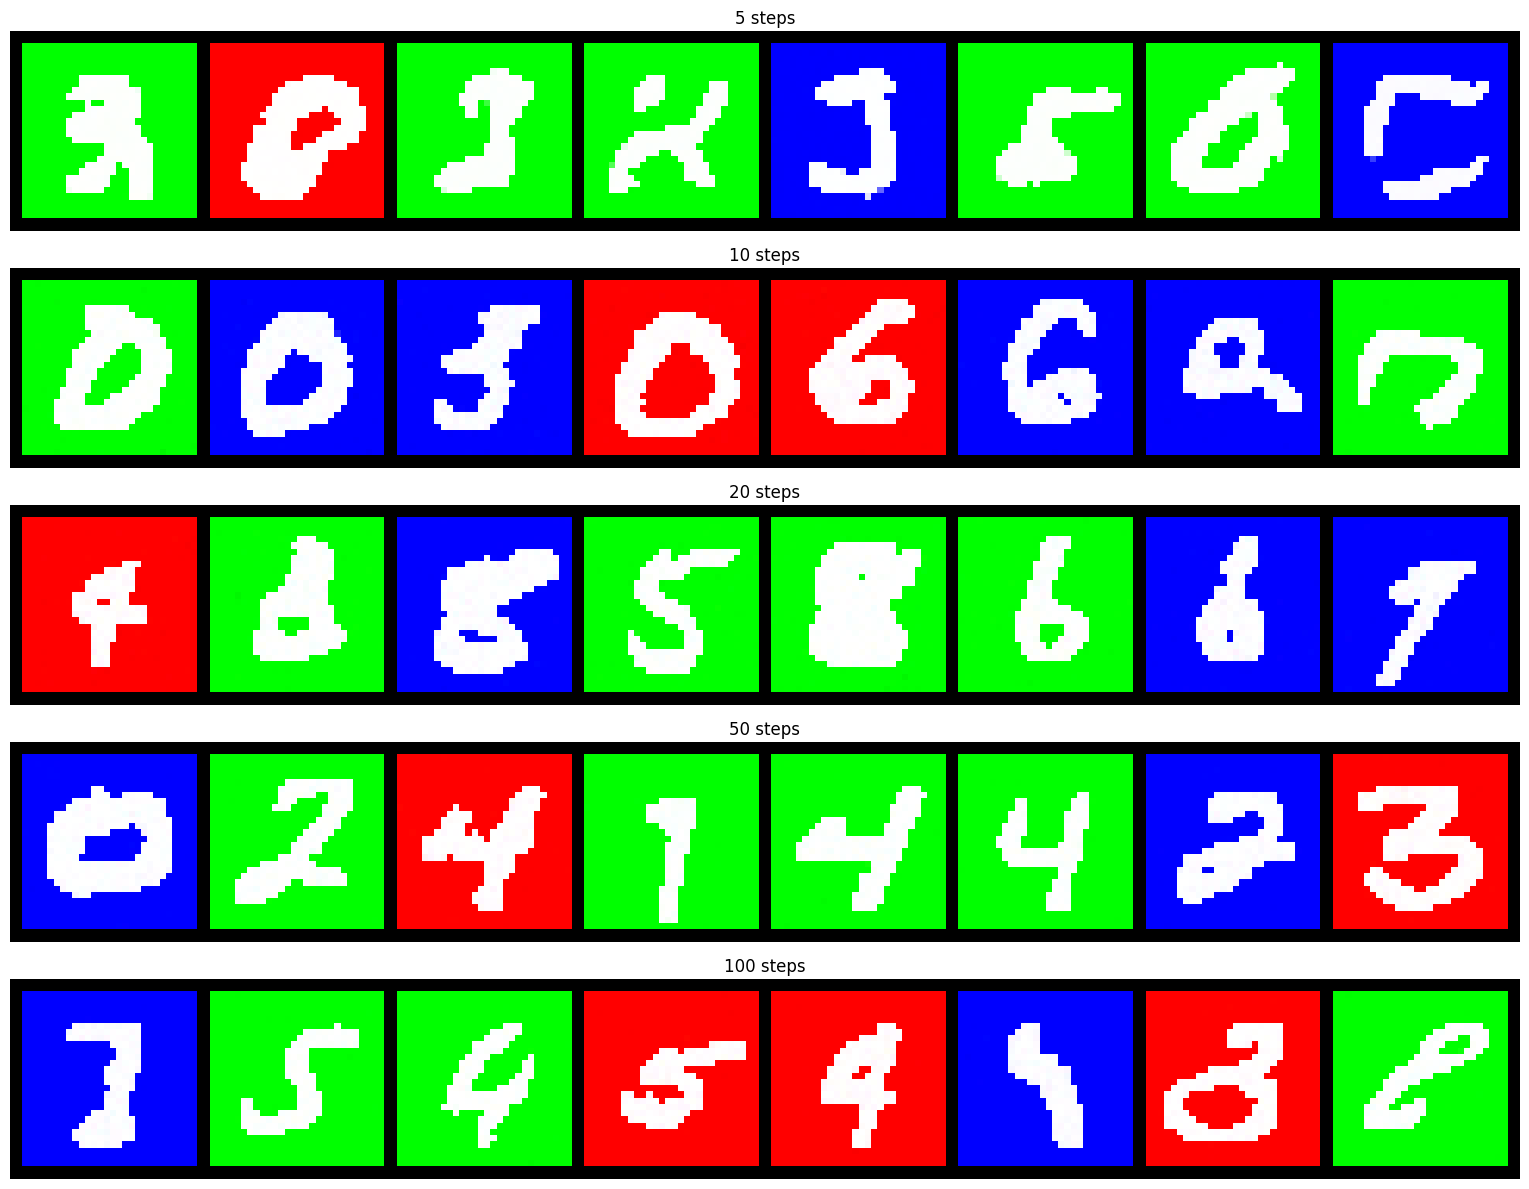

In [14]:
compare_results(results_steps)

---
## Experiment 2: Varying Solver Order

DEIS supports solver orders 1, 2, and 3. Higher orders can be more accurate but may be less stable.

In [16]:
# Test different solver orders
solver_orders = [1, 2, 3]
NUM_STEPS = 20

results_orders = {}

for order in solver_orders:
    print(f"\nSampling with solver order {order}...")
    
    scheduler = create_deis_scheduler(
        num_train_timesteps=TIMESTEPS,
        solver_order=order,
        beta_schedule="scaled_linear",
    )
    
    samples = sample_with_deis(
        unet=unet,
        scheduler=scheduler,
        num_inference_steps=NUM_STEPS,
        batch_size=16,
        image_size=IMAGE_SIZE,
        channels=CHANNELS,
        device=device
    )
    
    results_orders[f"Order {order}"] = {
        'samples': samples,
    }


Sampling with solver order 1...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver order 2...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver order 3...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

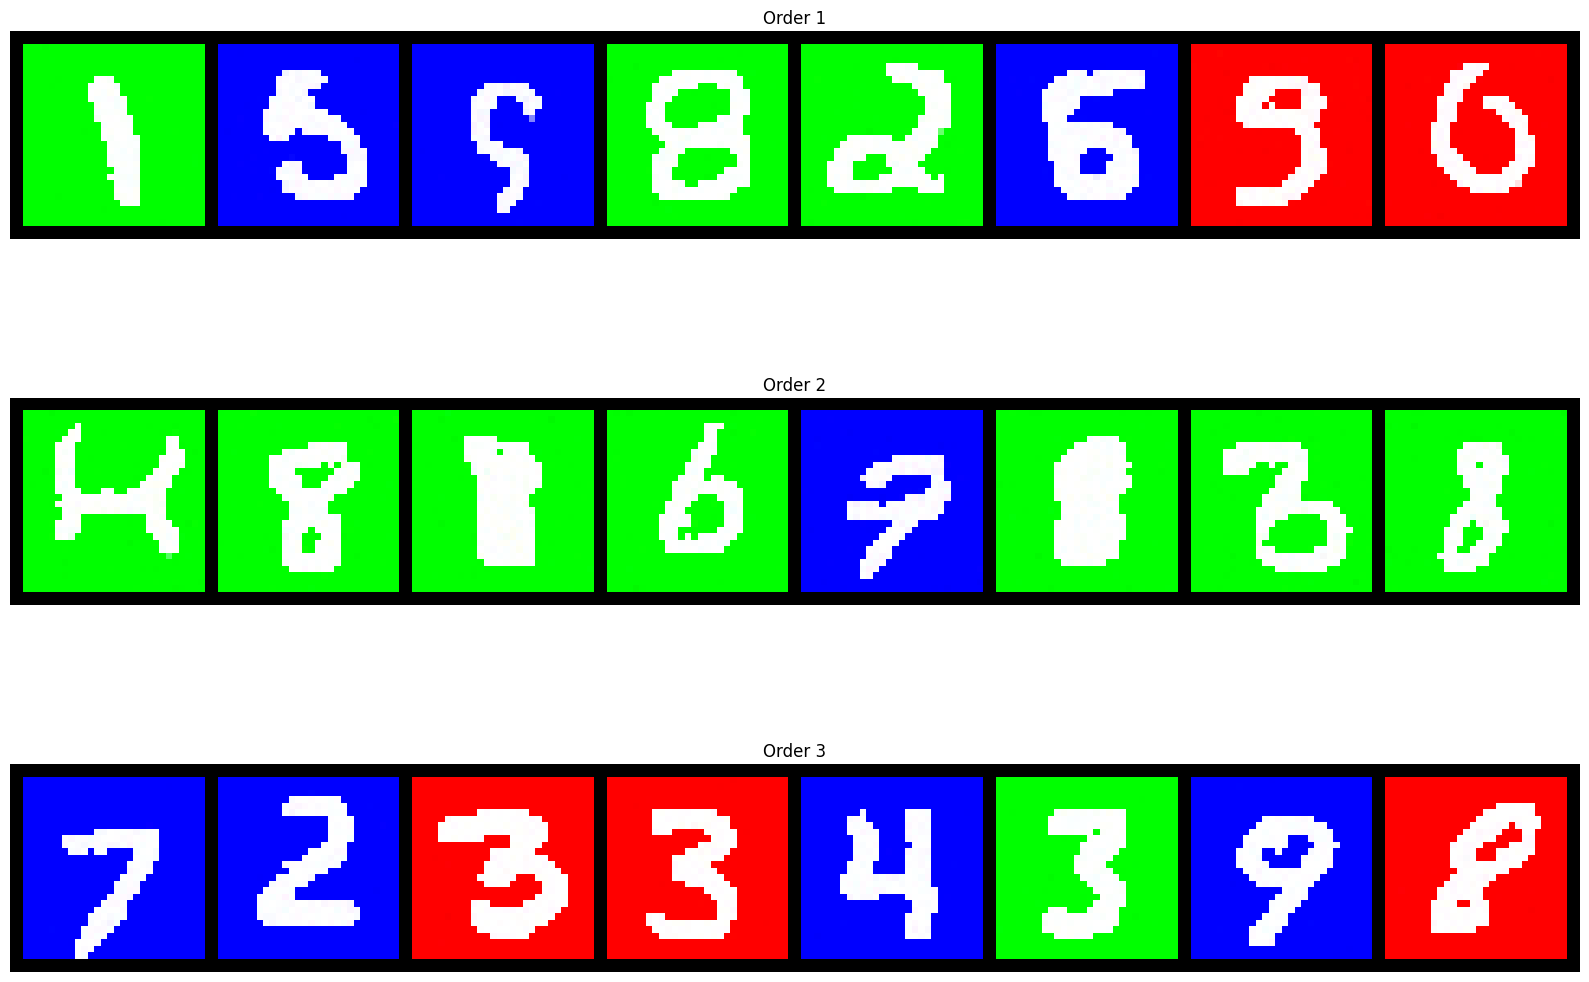

In [17]:
compare_results(results_orders)

---
## Experiment 3: Varying Beta Schedule

Test different noise schedules: linear, scaled_linear, and squaredcos_cap_v2.

In [19]:
beta_schedules = ["linear", "scaled_linear", "squaredcos_cap_v2"]
NUM_STEPS = 20

results_beta = {}

for beta_sched in beta_schedules:
    print(f"\nSampling with beta_schedule='{beta_sched}'...")
    
    scheduler = create_deis_scheduler(
        num_train_timesteps=TIMESTEPS,
        solver_order=2,
        beta_schedule=beta_sched,
    )
    
    samples = sample_with_deis(
        unet=unet,
        scheduler=scheduler,
        num_inference_steps=NUM_STEPS,
        batch_size=16,
        image_size=IMAGE_SIZE,
        channels=CHANNELS,
        device=device
    )
    
    results_beta[beta_sched] = {
        'samples': samples,
    }


Sampling with beta_schedule='linear'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with beta_schedule='scaled_linear'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with beta_schedule='squaredcos_cap_v2'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

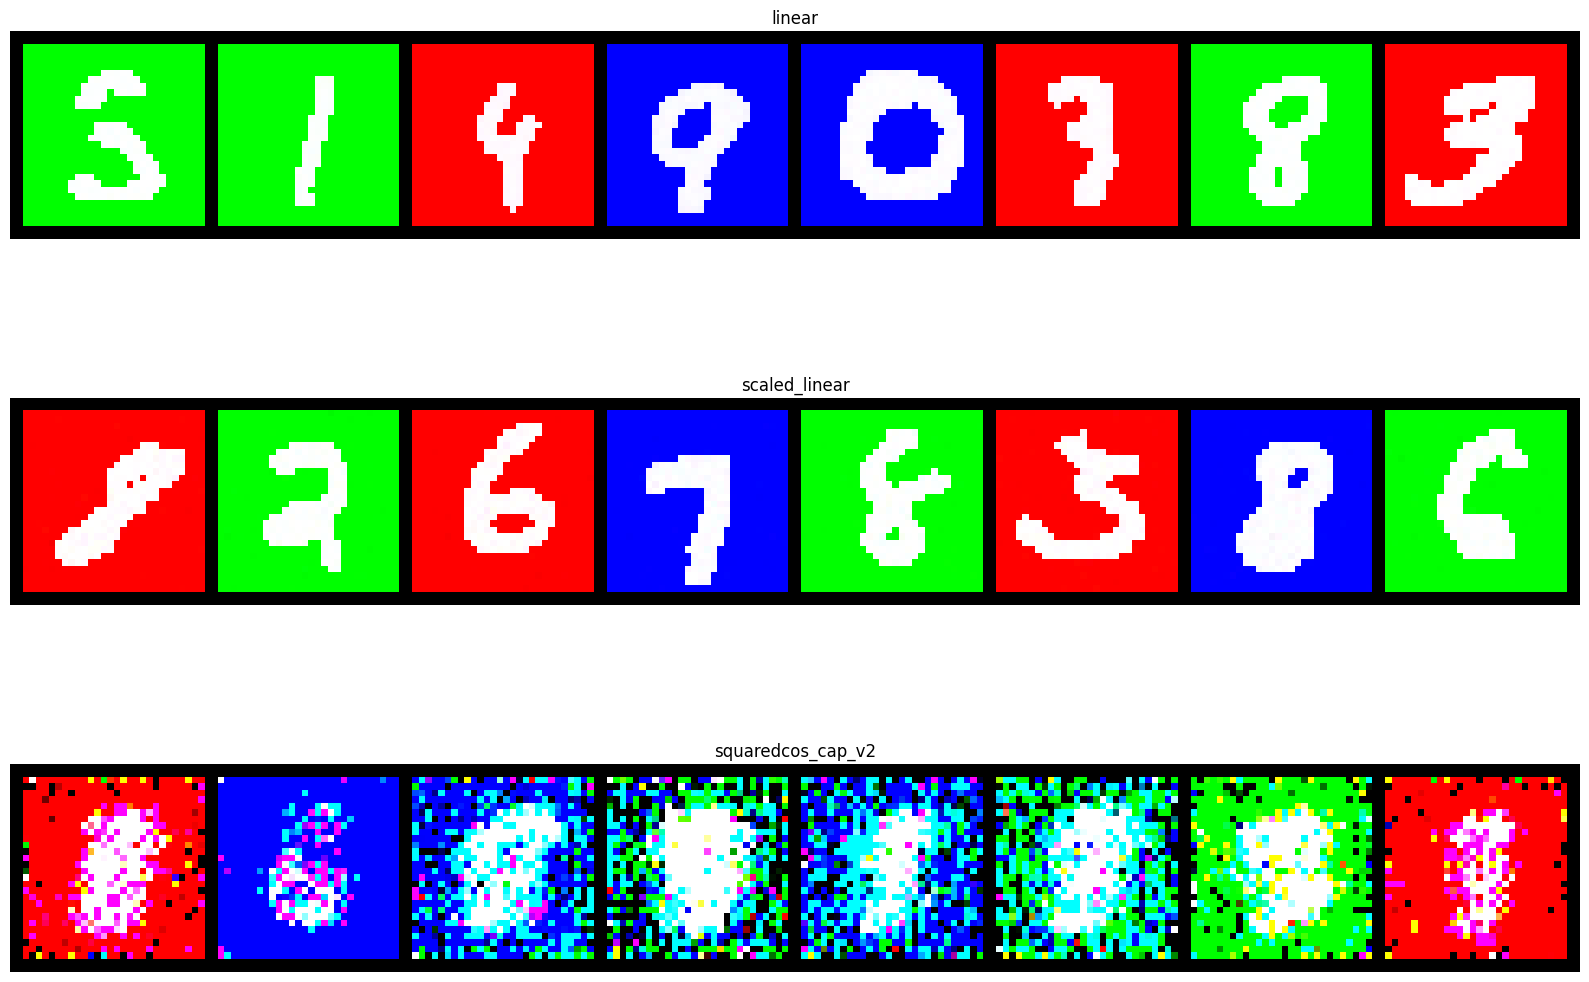

In [20]:
compare_results(results_beta)

---
## Experiment 4: Varying Solver Type

DEIS supports different solver types for polynomial interpolation.

In [21]:
# Test different solver types
solver_types = ["logrho", "midpoint", "heun", "bh1", "bh2"]
NUM_STEPS = 20

results_solver_type = {}

for solver_type in solver_types:
    print(f"\nSampling with solver_type='{solver_type}'...")
    
    try:
        scheduler = create_deis_scheduler(
            num_train_timesteps=TIMESTEPS,
            solver_order=2,
            beta_schedule="scaled_linear",
            solver_type=solver_type,
        )
        
        samples = sample_with_deis(
            unet=unet,
            scheduler=scheduler,
            num_inference_steps=NUM_STEPS,
            batch_size=16,
            image_size=IMAGE_SIZE,
            channels=CHANNELS,
            device=device
        )
        
        results_solver_type[solver_type] = {
            'samples': samples,
        }
    except Exception as e:
        print(f"  Error: {e}")


Sampling with solver_type='logrho'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver_type='midpoint'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver_type='heun'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver_type='bh1'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with solver_type='bh2'...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

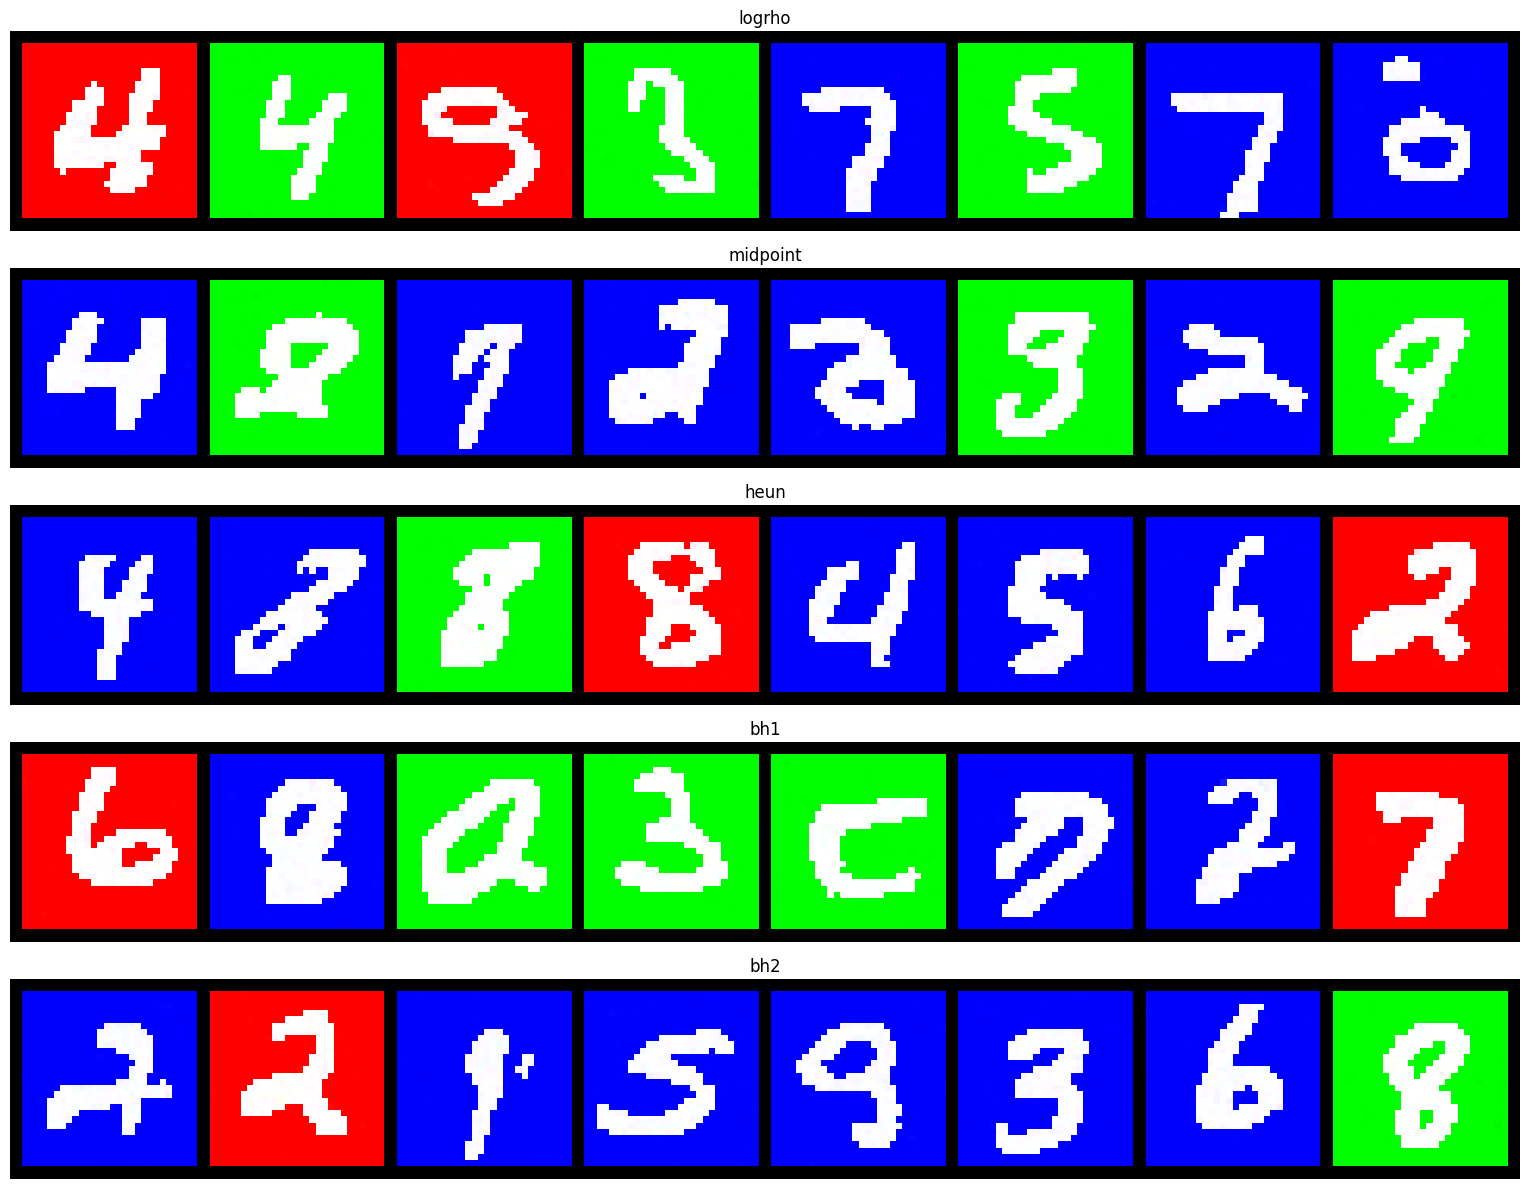

In [22]:
if results_solver_type:
    compare_results(results_solver_type)

---
## Experiment 5: Lower Order Final Steps

Test the effect of using lower order solver at final denoising steps.

In [24]:
# Test lower_order_final setting
lower_order_options = [True, False]
NUM_STEPS = 20

results_lower_order = {}

for lower_order in lower_order_options:
    print(f"\nSampling with lower_order_final={lower_order}...")
    
    scheduler = create_deis_scheduler(
        num_train_timesteps=TIMESTEPS,
        solver_order=3,
        beta_schedule="scaled_linear",
        lower_order_final=lower_order,
    )
    
    samples = sample_with_deis(
        unet=unet,
        scheduler=scheduler,
        num_inference_steps=NUM_STEPS,
        batch_size=16,
        image_size=IMAGE_SIZE,
        channels=CHANNELS,
        device=device
    )
    
    results_lower_order[f"lower_order_final={lower_order}"] = {
        'samples': samples,
    }


Sampling with lower_order_final=True...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]


Sampling with lower_order_final=False...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

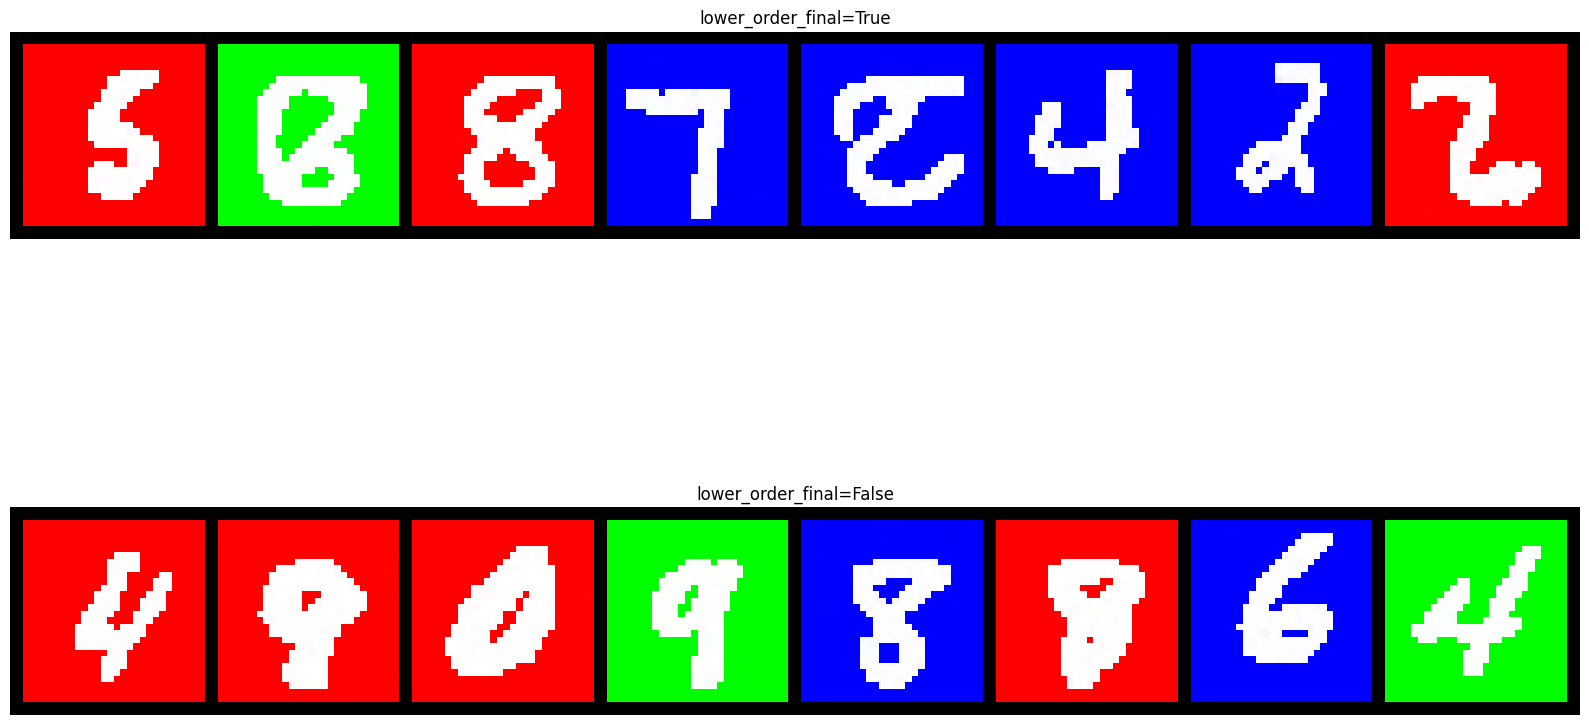

In [25]:
compare_results(results_lower_order)

---
## Experiment 6: Visualize Denoising Process

In [26]:
# Generate samples with intermediate steps
scheduler = create_deis_scheduler(
    num_train_timesteps=TIMESTEPS,
    solver_order=2,
    beta_schedule="scaled_linear",
)

samples, intermediates = sample_with_deis(
    unet=unet,
    scheduler=scheduler,
    num_inference_steps=20,
    batch_size=4,
    image_size=IMAGE_SIZE,
    channels=CHANNELS,
    device=device,
    return_intermediates=True
)

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

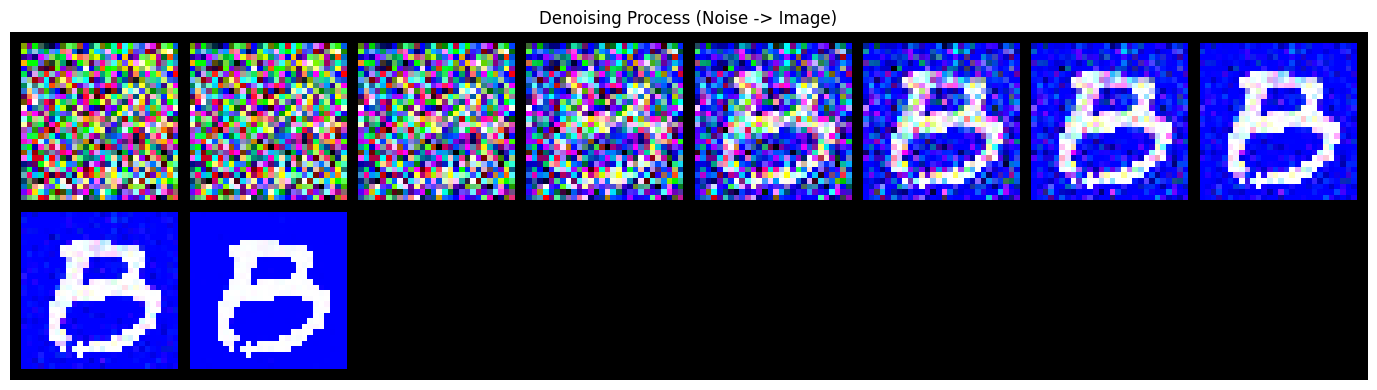

In [27]:
show_denoising_process(intermediates, num_steps_to_show=10)

---
## Experiment 7: Comparison with Baseline DDIM

In [28]:
# Compare DEIS with baseline DDIM sampling from the original model
NUM_STEPS = 20

# DEIS sampling
print("Sampling with DEIS...")
scheduler_deis = create_deis_scheduler(
    num_train_timesteps=TIMESTEPS,
    solver_order=2,
    beta_schedule="scaled_linear",
)

deis_samples = sample_with_deis(
    unet=unet,
    scheduler=scheduler_deis,
    num_inference_steps=NUM_STEPS,
    batch_size=16,
    image_size=IMAGE_SIZE,
    channels=CHANNELS,
    device=device
)

# Original DDIM sampling (from diffusion model)
print("Sampling with original DDIM...")
ema_model.sampling_timesteps = NUM_STEPS
with torch.no_grad():
    ddim_samples = ema_model.sample(batch_size=16)

Sampling with DEIS...


DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

Sampling with original DDIM...


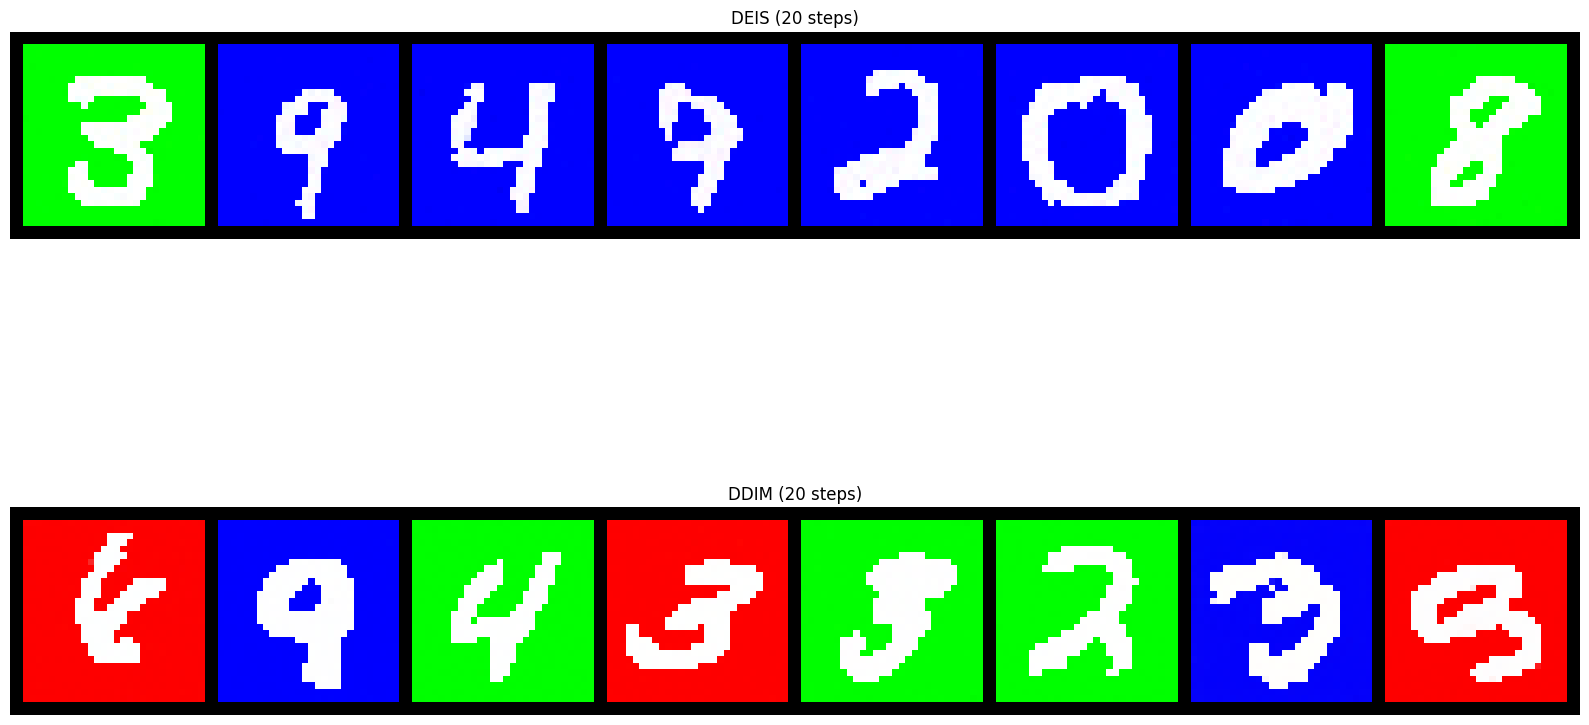

In [29]:
comparison_results = {
    f"DEIS ({NUM_STEPS} steps)": {'samples': deis_samples},
    f"DDIM ({NUM_STEPS} steps)": {'samples': ddim_samples},
}

compare_results(comparison_results)

---
## Experiment 9: FID-Based Quality Comparison

Compare different DEIS configurations using FID score for quantitative evaluation. Lower FID = better quality.


In [8]:
# Configuration for FID evaluation
REAL_IMAGES_DIR = "./data/testing"
NUM_FID_SAMPLES = 1000
FID_OUTPUT_DIR = Path("./results/fid_evaluation")
FID_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Will generate {NUM_FID_SAMPLES} samples for each configuration")
print(f"Real images directory: {REAL_IMAGES_DIR}")
print(f"Output directory: {FID_OUTPUT_DIR}")


Will generate 1000 samples for each configuration
Real images directory: ./data/testing
Output directory: results/fid_evaluation


In [9]:
def generate_samples(
    unet, 
    scheduler_config: dict, 
    num_samples: int,
    num_inference_steps: int,
    batch_size: int = 32,  # Reduced batch size to avoid OOM
):
    """Generate samples for FID evaluation."""
    scheduler = create_deis_scheduler(**scheduler_config)
    
    all_samples = []
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="Generating samples"):
        current_batch_size = min(batch_size, num_samples - i * batch_size)
        samples = sample_with_deis(
            unet=unet,
            scheduler=scheduler,
            num_inference_steps=num_inference_steps,
            batch_size=current_batch_size,
            image_size=IMAGE_SIZE,
            channels=CHANNELS,
            device=device
        )
        all_samples.append(samples.cpu())
        del samples  # Free GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return torch.cat(all_samples, dim=0)[:num_samples]


def evaluate_config_fid(
    config_name: str,
    scheduler_config: dict,
    num_inference_steps: int,
    num_samples: int = NUM_FID_SAMPLES,
):
    """Evaluate a DEIS configuration using FID score."""
    print(f"\n{'='*60}")
    print(f"Evaluating: {config_name}")
    print(f"Steps: {num_inference_steps}, Samples: {num_samples}")
    print(f"{'='*60}")
    
    # Generate samples
    start_time = time.time()
    samples = generate_samples(
        unet=unet,
        scheduler_config=scheduler_config,
        num_samples=num_samples,
        num_inference_steps=num_inference_steps,
    )
    gen_time = time.time() - start_time
    
    # Save samples to directory
    config_dir = FID_OUTPUT_DIR / config_name.replace(" ", "_").replace("=", "_")
    save_samples_to_dir(samples, config_dir)
    
    # Free GPU memory before FID computation
    del samples
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Compute FID
    print("Computing FID score...")
    fid_score = compute_fid(REAL_IMAGES_DIR, str(config_dir), device=device)
    
    print(f"Results for {config_name}:")
    print(f"  - Generation time: {gen_time:.2f}s ({num_samples/gen_time:.1f} samples/sec)")
    print(f"  - FID Score: {fid_score:.2f}")
    
    return {
        "config": config_name,
        "steps": num_inference_steps,
        "fid": fid_score,
        "gen_time": gen_time,
        "samples_per_sec": num_samples / gen_time,
    }


In [10]:
# Define configurations to evaluate
# Each config: (name, scheduler_config, num_steps)
fid_configs = [
    # Varying inference steps with Order 2
    ("DEIS Order2 10steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "scaled_linear"}, 10),
    ("DEIS Order2 20steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "scaled_linear"}, 20),
    # ("DEIS Order2 50steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "scaled_linear"}, 50),
    
    # # Varying solver order with 20 steps
    # ("DEIS Order1 20steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 1, "beta_schedule": "scaled_linear"}, 20),
    # ("DEIS Order3 20steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 3, "beta_schedule": "scaled_linear"}, 20),
    
    # # Different beta schedules with Order 2, 20 steps
    # ("DEIS linear 20steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "linear"}, 20),
    # ("DEIS cosine 20steps", {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "squaredcos_cap_v2"}, 20),
]

print(f"Will evaluate {len(fid_configs)} configurations")


Will evaluate 2 configurations


In [11]:
# Run FID evaluation for all configurations
fid_results = []

for config_name, scheduler_config, num_steps in fid_configs:
    # try:
    result = evaluate_config_fid(
        config_name=config_name,
        scheduler_config=scheduler_config,
        num_inference_steps=num_steps,
        num_samples=NUM_FID_SAMPLES,
    )
    fid_results.append(result)
    # except Exception as e:
    #     print(f"Error evaluating {config_name}: {e}")
    #     continue

print(f"\n{'='*60}")
print("FID Evaluation Complete!")
print(f"{'='*60}")



Evaluating: DEIS Order2 10steps
Steps: 10, Samples: 1000


Generating samples:   0%|          | 0/32 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Computing FID score...
Results for DEIS Order2 10steps:
  - Generation time: 5.24s (190.8 samples/sec)
  - FID Score: 12.38

Evaluating: DEIS Order2 20steps
Steps: 20, Samples: 1000


Generating samples:   0%|          | 0/32 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

Computing FID score...
Results for DEIS Order2 20steps:
  - Generation time: 9.22s (108.4 samples/sec)
  - FID Score: 8.47

FID Evaluation Complete!


In [12]:
fid_results

[{'config': 'DEIS Order2 10steps',
  'steps': 10,
  'fid': 12.376904487609863,
  'gen_time': 5.240754127502441,
  'samples_per_sec': 190.81223344407587},
 {'config': 'DEIS Order2 20steps',
  'steps': 20,
  'fid': 8.469389915466309,
  'gen_time': 9.221044778823853,
  'samples_per_sec': 108.44758093968939}]

In [14]:
# Create summary table
import pandas as pd

fid_df = pd.DataFrame(fid_results)
fid_df = fid_df.sort_values("fid")

print("\n" + "="*80)
print("FID SCORES COMPARISON (sorted by FID, lower is better)")
print("="*80)
print(fid_df.to_string(index=False))
print("="*80)

# Find best configuration
best_config = fid_df.iloc[0]
print(f"\nBest Configuration: {best_config['config']}")
print(f"   FID Score: {best_config['fid']:.2f}")
print(f"   Inference Steps: {best_config['steps']}")
print(f"   Speed: {best_config['samples_per_sec']:.1f} samples/sec")



FID SCORES COMPARISON (sorted by FID, lower is better)
             config  steps       fid  gen_time  samples_per_sec
DEIS Order2 20steps     20  8.469390  9.221045       108.447581
DEIS Order2 10steps     10 12.376904  5.240754       190.812233

Best Configuration: DEIS Order2 20steps
   FID Score: 8.47
   Inference Steps: 20
   Speed: 108.4 samples/sec


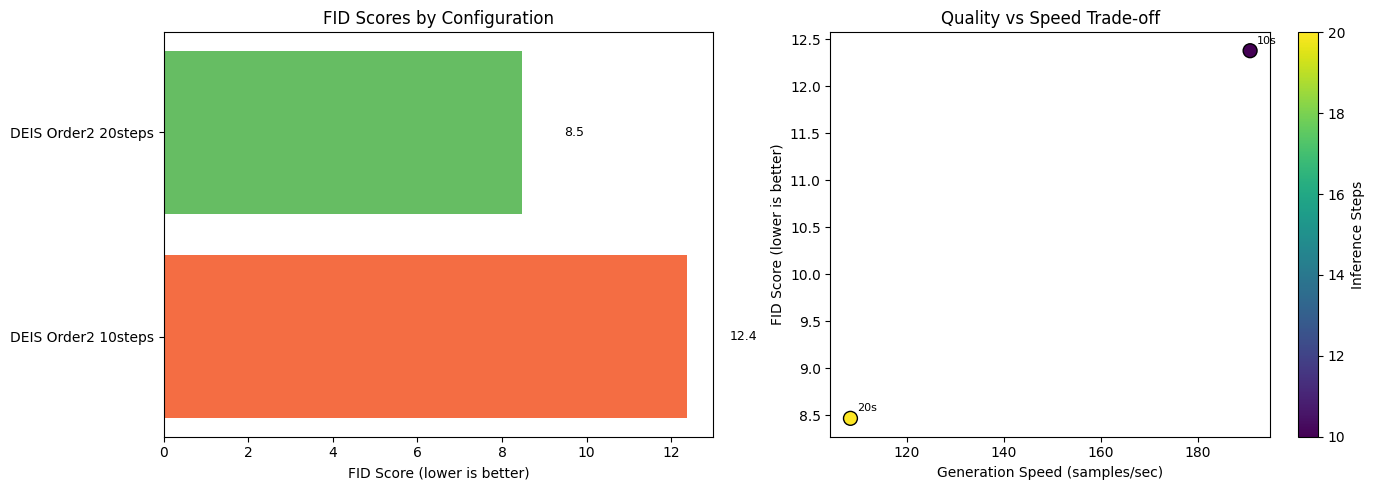


Visualization saved to results/fid_evaluation/fid_comparison.png


In [15]:
# Visualize FID results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: FID Scores bar chart
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(fid_df)))  # Red=bad, Green=good
bars = ax1.barh(fid_df['config'], fid_df['fid'], color=colors)
ax1.set_xlabel('FID Score (lower is better)')
ax1.set_title('FID Scores by Configuration')
ax1.invert_yaxis()  # Best at top

# Add value labels
for bar, fid in zip(bars, fid_df['fid']):
    ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{fid:.1f}', va='center', fontsize=9)

# Plot 2: FID vs Speed trade-off
ax2 = axes[1]
scatter = ax2.scatter(fid_df['samples_per_sec'], fid_df['fid'], 
                       c=fid_df['steps'], cmap='viridis', s=100, edgecolors='black')
ax2.set_xlabel('Generation Speed (samples/sec)')
ax2.set_ylabel('FID Score (lower is better)')
ax2.set_title('Quality vs Speed Trade-off')

# Add labels to points
for _, row in fid_df.iterrows():
    ax2.annotate(f"{row['steps']}s", (row['samples_per_sec'], row['fid']),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.colorbar(scatter, ax=ax2, label='Inference Steps')
plt.tight_layout()
plt.savefig(FID_OUTPUT_DIR / "fid_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {FID_OUTPUT_DIR / 'fid_comparison.png'}")


### Compare DEIS vs Baseline DDIM using FID


In [16]:
# Compare DEIS vs baseline DDIM using FID
COMPARE_STEPS = 20
COMPARE_SAMPLES = NUM_FID_SAMPLES

comparison_results = []

# DEIS sampling
print("Generating DEIS samples for FID comparison...")
deis_scheduler_config = {"num_train_timesteps": TIMESTEPS, "solver_order": 2, "beta_schedule": "scaled_linear"}
deis_result = evaluate_config_fid(
    config_name=f"DEIS (Order 2, {COMPARE_STEPS} steps)",
    scheduler_config=deis_scheduler_config,
    num_inference_steps=COMPARE_STEPS,
    num_samples=COMPARE_SAMPLES,
)
comparison_results.append(deis_result)

# Baseline DDIM sampling
print("\nGenerating baseline DDIM samples for FID comparison...")
ddim_output_dir = FID_OUTPUT_DIR / f"DDIM_{COMPARE_STEPS}steps"
ddim_output_dir.mkdir(parents=True, exist_ok=True)

ema_model.sampling_timesteps = COMPARE_STEPS
start_time = time.time()

all_ddim_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDIM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    with torch.no_grad():
        samples = ema_model.sample(batch_size=current_batch_size)
    all_ddim_samples.append(samples.cpu())

ddim_samples = torch.cat(all_ddim_samples, dim=0)[:COMPARE_SAMPLES]
ddim_gen_time = time.time() - start_time

# Save DDIM samples
save_samples_to_dir(ddim_samples, ddim_output_dir)

# Compute DDIM FID
print("Computing DDIM FID score...")
ddim_fid = compute_fid(REAL_IMAGES_DIR, str(ddim_output_dir), device=device)

comparison_results.append({
    "config": f"DDIM Baseline ({COMPARE_STEPS} steps)",
    "steps": COMPARE_STEPS,
    "fid": ddim_fid,
    "gen_time": ddim_gen_time,
    "samples_per_sec": COMPARE_SAMPLES / ddim_gen_time,
})

print(f"\nDDIM Results:")
print(f"  - Generation time: {ddim_gen_time:.2f}s")
print(f"  - FID Score: {ddim_fid:.2f}")


Generating DEIS samples for FID comparison...

Evaluating: DEIS (Order 2, 20 steps)
Steps: 20, Samples: 1000


Generating samples:   0%|          | 0/32 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

DEIS Sampling:   0%|          | 0/20 [00:00<?, ?it/s]

Computing FID score...
Results for DEIS (Order 2, 20 steps):
  - Generation time: 9.14s (109.4 samples/sec)
  - FID Score: 8.54

Generating baseline DDIM samples for FID comparison...


Generating DDIM samples:   0%|          | 0/16 [00:00<?, ?it/s]

Computing DDIM FID score...

DDIM Results:
  - Generation time: 4.49s
  - FID Score: 11.51



DEIS vs DDIM COMPARISON
                  config  steps       fid  gen_time  samples_per_sec
DEIS (Order 2, 20 steps)     20  8.542498  9.140446       109.403855
DDIM Baseline (20 steps)     20 11.507077  4.491260       222.654665


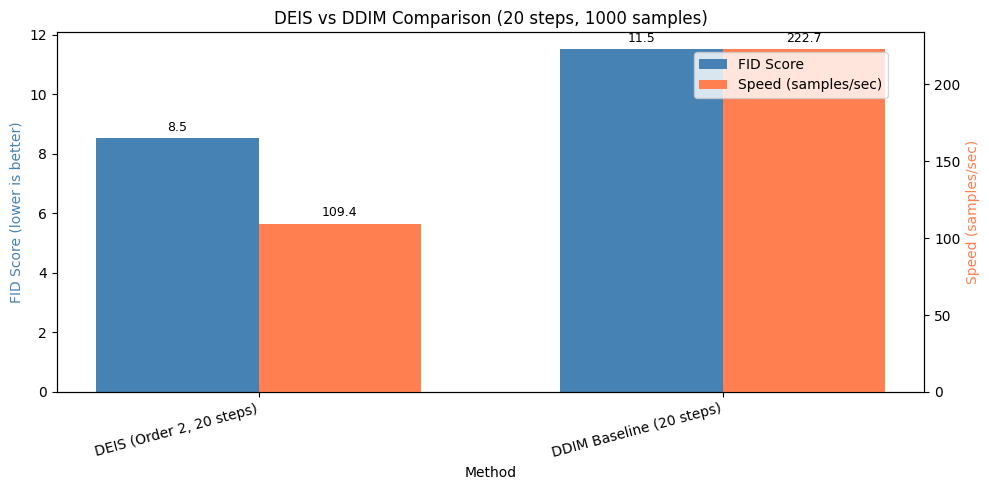


📊 Summary:
   DEIS FID: 8.54
   DDIM FID: 11.51
   ✅ DEIS is 25.8% better than DDIM in FID score


In [17]:
# Visualize DEIS vs DDIM comparison
comparison_df = pd.DataFrame(comparison_results)

print("\n" + "="*60)
print("DEIS vs DDIM COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['fid'], width, label='FID Score', color='steelblue')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, comparison_df['samples_per_sec'], width, label='Speed (samples/sec)', color='coral')

ax.set_xlabel('Method')
ax.set_ylabel('FID Score (lower is better)', color='steelblue')
ax2.set_ylabel('Speed (samples/sec)', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['config'], rotation=15, ha='right')
ax.set_title(f'DEIS vs DDIM Comparison ({COMPARE_STEPS} steps, {COMPARE_SAMPLES} samples)')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.savefig(FID_OUTPUT_DIR / "deis_vs_ddim_fid.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary
deis_fid = comparison_df[comparison_df['config'].str.contains('DEIS')]['fid'].values[0]
ddim_fid = comparison_df[comparison_df['config'].str.contains('DDIM')]['fid'].values[0]
improvement = ((ddim_fid - deis_fid) / ddim_fid) * 100

print(f"\n📊 Summary:")
print(f"   DEIS FID: {deis_fid:.2f}")
print(f"   DDIM FID: {ddim_fid:.2f}")
if deis_fid < ddim_fid:
    print(f"   ✅ DEIS is {improvement:.1f}% better than DDIM in FID score")
else:
    print(f"   ⚠️ DDIM performs {-improvement:.1f}% better than DEIS in FID score")


---
## Save Best Configuration Samples

DEIS Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Saved samples to results/deis_samples


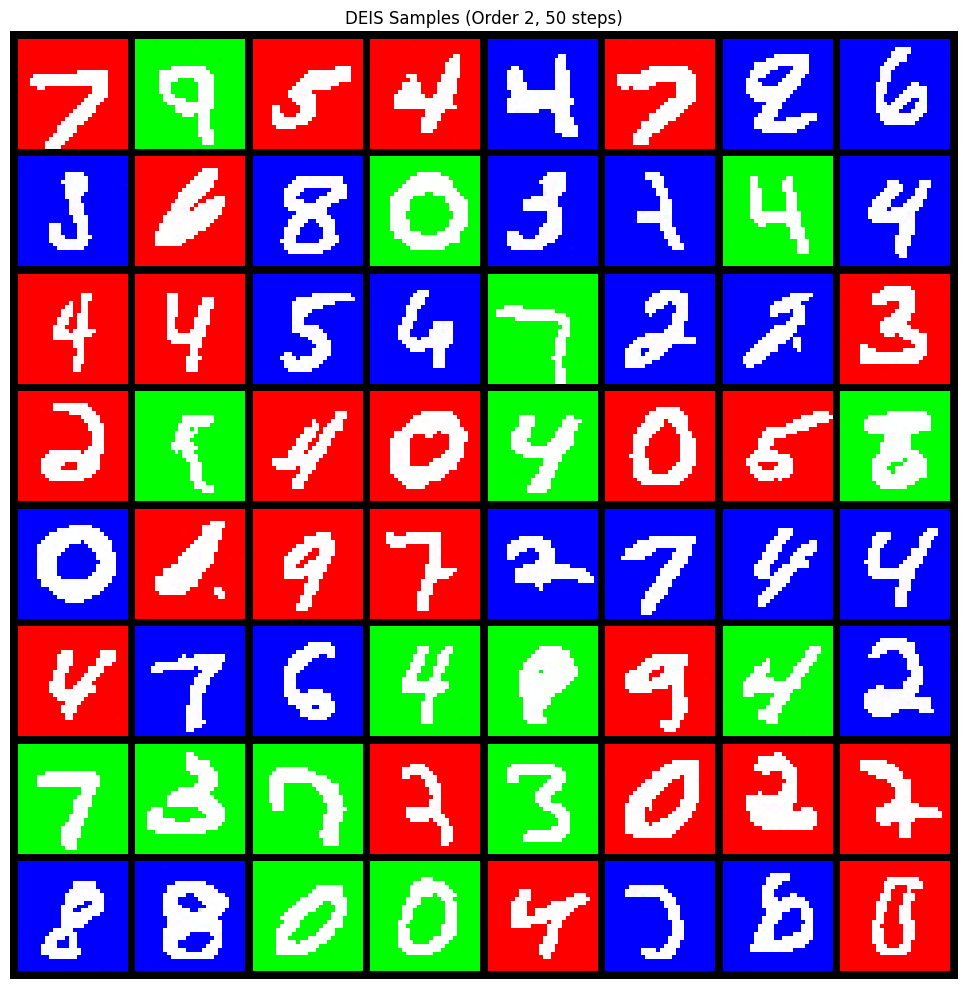

In [19]:
# Generate high-quality samples with optimal configuration
OUTPUT_DIR = Path("./results/deis_samples")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Best configuration (adjust based on experiments)
scheduler = create_deis_scheduler(
    num_train_timesteps=TIMESTEPS,
    solver_order=2,
    beta_schedule="scaled_linear",
    solver_type="logrho",
    lower_order_final=True,
)

samples = sample_with_deis(
    unet=unet,
    scheduler=scheduler,
    num_inference_steps=50,
    batch_size=64,
    image_size=IMAGE_SIZE,
    channels=CHANNELS,
    device=device
)

# Save grid
save_image(samples, OUTPUT_DIR / "deis_samples_grid.png", nrow=8)
print(f"Saved samples to {OUTPUT_DIR}")

# Show samples
show_samples(samples, title="DEIS Samples (Order 2, 50 steps)", nrow=8)